In [206]:
import urllib.request
import urllib,os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from netCDF4 import Dataset
import warnings
warnings.filterwarnings('ignore')

import numlabs.lab5.lab5_funs
from importlib import reload
reload(numlabs.lab5.lab5_funs)
from numlabs.lab5.lab5_funs import Integrator
from collections import namedtuple
import numpy as np

download=False
the_file='case_60_10.nc'
the_url="http://clouds.eos.ubc.ca/~phil/docs/atsc500/data/{}".format(the_file)
if download:
    out=urllib.request.urlretrieve(the_url,the_file)
    print(out)
print("download {}: size is {:8.4g} Mbytes".format(the_file,os.path.getsize(the_file)*1.e-6))

download case_60_10.nc: size is    499.3 Mbytes


In [207]:
!ncdump -h case_60_10.nc

netcdf case_60_10 {
dimensions:
	time = 48 ;
	x = 25 ;
	y = 20 ;
	z = 130 ;
variables:
	float time(time) ;
		string time:units = "minutes" ;
	float x(x) ;
		string x:units = "meters" ;
	float y(y) ;
		string y:units = "meters" ;
	float z(z) ;
		string z:units = "meters" ;
	float press(z) ;
		string press:units = "Pa" ;

// global attributes:
		:heat_flux_W_m2 = 100L ;
		:gamma_K_km = 10L ;

group: c1 {
  variables:
  	float TABS(time, z, y, x) ;
  		string TABS:units = "K" ;
  	float W(time, z, y, x) ;
  		string W:units = "m/s" ;
  	float U(time, z, y, x) ;
  		string U:units = "m/s" ;
  	float V(time, z, y, x) ;
  		string V:units = "m/s" ;
  } // group c1

group: c2 {
  variables:
  	float TABS(time, z, y, x) ;
  		string TABS:units = "K" ;
  	float W(time, z, y, x) ;
  		string W:units = "m/s" ;
  	float U(time, z, y, x) ;
  		string U:units = "m/s" ;
  	float V(time, z, y, x) ;
  		string V:units = "m/s" ;
  } // group c2

group: c3 {
  variables:
  	float TABS(time, z, y, x) ;
  

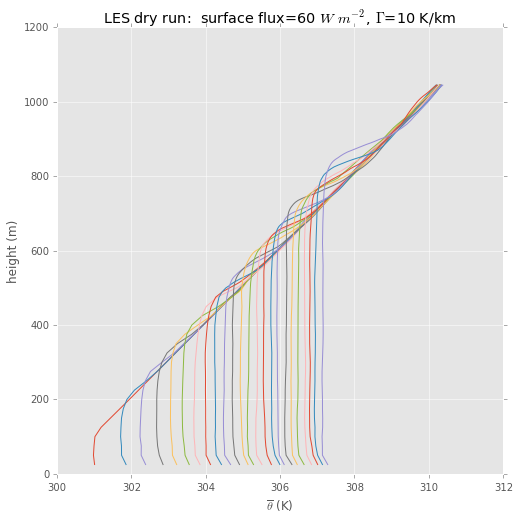

In [208]:
import matplotlib.pyplot as plt

%matplotlib inline

def make_theta(temp,press):
    """
      temp in K
      press in Pa
      returns theta in K
    """
    p0=1.e5
    Rd=287.
    cpd=1004.
    theta=temp*(p0/press)**(Rd/cpd)
    return theta

case_name='case_60_10.nc'
ensemble='c1'
with Dataset(case_name,'r') as ncin:
    group = ncin.groups['c1']
    temp=group.variables['TABS'][...]
    press=ncin.variables['press'][...]
    uvel =group.variables['U'][...]
    vvel =group.variables['V'][...]
    wvel =group.variables['W'][...]
    z = ncin.variables['z'][...]
    y = ncin.variables['y'][...]
    x = ncin.variables['x'][...]
tempprof=temp.mean(axis=3).mean(axis=2)

plt.close('all')
plt.style.use('ggplot')
fig,ax=plt.subplots(1,1,figsize=(8,8))
for i in np.arange(0,temp.shape[0],2):
    theta = make_theta(tempprof[i,:],press)
    ax.plot(theta,z)
ax.set(xlabel=r'$\overline{\theta}$ (K)',ylabel='height (m)',
       title='LES dry run:  surface flux=60 $W\,m^{-2}$, $\Gamma$=10 K/km')
#np.arange(0,temp.shape[0],2)
#tempprof[1,1]
#make_theta(tempprof[1,:],press)
#temp.mean(axis=0).mean(axis=1).mean(axis=1)

In [239]:
reload(numlabs.lab5.lab5_funs)
from numlabs.lab5.lab5_funs import Integrator
from collections import namedtuple
import numpy as np


class IntegPM(Integrator):

    def set_yinit(self):
        #
        # read in 'mean wind speed - not doing this yet'
        #
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        #
        # read in 'initial locations'
        #
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        self.yinit = np.array(
            [self.initvars.initialx, self.initvars.initialy, self.initvars.initialz])
        self.nvars = len(self.yinit)
        return None

    def __init__(self, coeff_file_name):
        super().__init__(coeff_file_name)
        self.set_yinit()

    def getvel(t1,z,y,x,vel):
        #produces an averaged velocity for values between 
        #data points 
    
        # Args:
        #   t- time variable
        #   x,y,z - decimal spacial coordinates 
        #   vel - the velocity field, one of:
        #   uvel, vvel, wvel
        # Returns:
        #   the new velicities in the u,v,w.
    
        # sort out the x variables
        xtop  = np.ceil(x)
        xbot  = np.floor(x)
        txdif = x - xbot
    
        # sort out the y variables
    
        ytop  = np.ceil(y)
        ybot  = np.floor(y)
        tydif = y - ybot
    
        # sort out the z variables
        ztop  = np.ceil(z)
        zbot  = np.floor(z)
        tzdif = z - zbot
    
        # calculate average velocity at any given piont
        uA = (vel[t1,ztop,ytop,xtop]*(1.-tzdif)*(1.-tydif)*(1.-txdif))
        uB = (vel[t1,ztop,ybot,xbot]*(1.-tzdif)*(1.-tydif)*txdif)
        uC = (vel[t1,zbot,ytop,xtop]*(1.-tzdif)*tydif     *txdif)
        uD = (vel[t1,zbot,ytop,xbot]*(1.-tzdif)*tydif     *(1.-txdif))
        uE = (vel[t1,ztop,ybot,xbot]*(tzdif)   *(1.-tydif)*(1.-txdif))
        uF = (vel[t1,ztop,ybot,xtop]*(tzdif)   *(1.-tydif)*(txdif) )
        uG = (vel[t1,ztop,ytop,xtop]*(tzdif)   *(tydif)   *(txdif))
        uH = (vel[t1,ztop,ytop,xbot]*(tzdif)   *(tydif)   *(1.-txdif))
    
        # add all pionts together and return value
        nuVel = (uA + uB + uC + uD + uE + uF + uG + uH)
        return(nuVel)
   
    def derivs5(self, y, t):
        """y[0]= starting x position
           y[1]= starting y position
           y[2]= starting z position
        """
        # create a 1 x 2 element vector to hold the derivitive
        f = np.empty_like(y)
        f[0] = y[0] + getvel(1,y[2],y[1],y[0],uvel)
        f[1] = y[1] + getvel(1,y[2],y[1],y[0],vvel)
        f[2] = y[2] + getvel(1,y[2],y[1],y[0],wvel)

        return (f)

In [240]:
theSolver=IntegPM('project1.yaml')
timeVals,yVals,errorList=theSolver.timeloop5fixed()
print(yVals)



IndexError: index 20 is out of bounds for axis 2 with size 20

In [ ]:
def getvel(t,z,y,x,vel):
        #produces an averaged velocity for values between 
        #data points 

        # Args:
        #   t- time variable
        #   x,y,z - decimal spacial coordinates 
        #   vel - the velocity field, one of:
        #   uvel, vvel, wvel
        # Returns:
        #   the new velicities in the u,v,w.
    
        # sort out the x variables
        xtop  = np.ceil(x)
        xbot  = np.floor(x)
        txdif = x - xbot
    
        # sort out the y variables
    
        ytop  = np.ceil(y)
        ybot  = np.floor(y)
        tydif = y - ybot
    
        # sort out the z variables
        ztop  = np.ceil(z)
        zbot  = np.floor(z)
        tzdif = z - zbot
    
        # calculate average velocity at any given piont
        uA = (vel[t,ztop,ytop,xtop]*(1.-tzdif)*(1.-tydif)*(1.-txdif))
        uB = (vel[t,ztop,ybot,xbot]*(1.-tzdif)*(1.-tydif)*txdif)
        uC = (vel[t,zbot,ytop,xtop]*(1.-tzdif)*tydif     *txdif)
        uD = (vel[t,zbot,ytop,xbot]*(1.-tzdif)*tydif     *(1.-txdif))
        uE = (vel[t,ztop,ybot,xbot]*(tzdif)   *(1.-tydif)*(1.-txdif))
        uF = (vel[t,ztop,ybot,xtop]*(tzdif)   *(1.-tydif)*(txdif) )
        uG = (vel[t,ztop,ytop,xtop]*(tzdif)   *(tydif)   *(txdif))
        uH = (vel[t,ztop,ytop,xbot]*(tzdif)   *(tydif)   *(1.-txdif))
    
        # add all pionts together and return value
        nuVel = (uA + uB + uC + uD + uE + uF + uG + uH)
        return(nuVel)

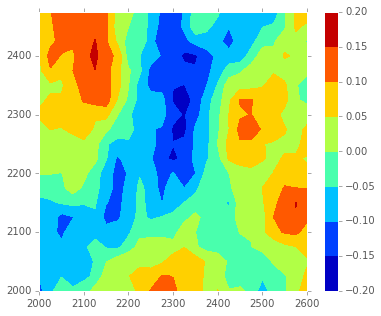

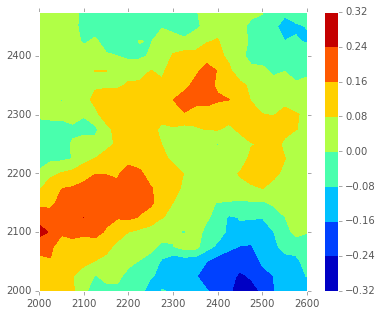

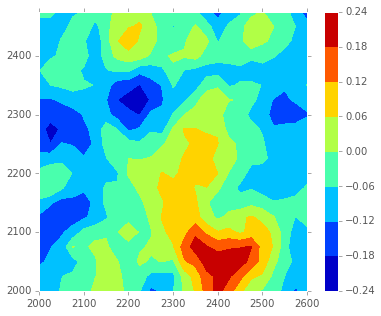

In [211]:
fig,ax = plt.subplots(1,1,figsize=(6,5))
a = ax.contourf(x,y,uvel[20,120,:,:])
#b = ax[1].contourf(x,y,vvel[20,120,:,:])
#c = ax[2].contourf(x,y,wvel[20,120,:,:])

cbar = plt.colorbar(a)

fig,ax = plt.subplots(1,1,figsize=(6,5))
#a = ax.contourf(x,y,uvel[20,120,:,:])
b = ax.contourf(x,y,vvel[20,120,:,:])
#c = ax[2].contourf(x,y,wvel[20,120,:,:])
cbar = plt.colorbar(b)

fig,ax = plt.subplots(1,1,figsize=(6,5))
#a = ax.contourf(x,y,uvel[20,120,:,:])
#b = ax[1].contourf(x,y,vvel[20,120,:,:])
c = ax.contourf(x,y,wvel[20,120,:,:])

cbar = plt.colorbar(c)
